## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import time

import pandas as pd
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn import metrics

import pickle

## Data

In [2]:
#3x28x28 matrix of numbers images
with open('train-images.idx3-ubyte','rb') as f:
    magic, size  = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data_images  = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    data_images  = data_images.reshape((size, nrows, ncols))
    data_images  = data_images[8:]

#labels from the images previously loaded
with open('train-labels.idx1-ubyte','rb') as f:
    magic, size  = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data_labels  = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>')).astype('str')

## ETL and batching 

In [3]:
# separating test and train sets 
X_train, X_test, y_train, y_test = train_test_split(data_images.reshape((59992,28*28)),data_labels,
                                                    train_size=0.92, random_state=42)

## Model Loading

In [4]:
# loading the trained models
lr_model = pickle.load(open('LogisticRegression.sav', 'rb'))

dt_model = pickle.load(open('DecisionTree.sav', 'rb'))

rf_model = pickle.load(open('RandomForest.sav', 'rb'))

xgrb_model = pickle.load(open('XGRB.sav', 'rb'))

## Model Prediction

In [5]:
# using the loaded models to predict y_test and y_train

# Logistic Regression
y_pred_lr    = lr_model.predict(X_test)

y_train_lr   = lr_model.predict(X_train)

# Decision Tree
y_pred_dt    = dt_model.predict(X_test)

y_train_dt   = dt_model.predict(X_train)

# Random Forest
y_pred_rf    = rf_model.predict(X_test)

y_train_rf   = rf_model.predict(X_train)

# XG Boost
y_pred_xgrb  = xgrb_model.predict(X_test)

y_train_xgrb = xgrb_model.predict(X_train)

## Prediction Score and Result Dataframe

In [6]:
# calculating the accuracy of each model
accuracy_lr            = round(metrics.accuracy_score(y_test , y_pred_lr),2)
accuracy_lr_train      = round(metrics.accuracy_score(y_train, y_train_lr),2)

accuracy_dt            = round(metrics.accuracy_score(y_test , y_pred_dt),2)
accuracy_dt_train      = round(metrics.accuracy_score(y_train, y_train_dt),2)

accuracy_fr            = round(metrics.accuracy_score(y_test , y_pred_rf),2)
accuracy_fr_train      = round(metrics.accuracy_score(y_train, y_train_rf),2)

accuracy_xgbr          = round(metrics.accuracy_score(y_test.astype(np.float64) , y_pred_xgrb),2)
accuracy_xgbr_train    = round(metrics.accuracy_score(y_train.astype(np.float64), y_train_xgrb),2)

In [7]:
# creating a dataframe with the accuracy of each model with train and test data
model_accuracy = pd.DataFrame({"Model"   : ["LR", "DT", "RF", "XGRB"],
                               "Test_AC" : [accuracy_lr, accuracy_dt, accuracy_fr, accuracy_xgbr],
                               "Train_AC": [accuracy_lr_train, accuracy_dt_train, accuracy_fr_train, accuracy_xgbr_train]})

model_accuracy.set_index('Model',inplace=True)

In [8]:
# calculating the F1 of each model
f1_lr   = round(metrics.f1_score(y_test , y_pred_lr, average='weighted'),2)

f1_dt   = round(metrics.f1_score(y_test , y_pred_dt, average='weighted'),2)

f1_fr   = round(metrics.f1_score(y_test , y_pred_rf, average='weighted'),2)

f1_xgbr = round(metrics.f1_score(y_test.astype(np.float64) , y_pred_xgrb, average='weighted'),2)

In [9]:
# creating a dataframe with the accuracy of each model with train and test data
model_f1 = pd.DataFrame({"Model"   : ["LR", "DT", "RF", "XGRB"],
                         "Test_F1" : [f1_lr, f1_dt, f1_fr, f1_xgbr]})

model_f1.set_index('Model',inplace=True)

In [10]:
# making a dataframe for each prediction with the original and pred values

# Logistic Regression
pred_lr = pd.DataFrame({'real':y_test.astype(int), 'pred':y_pred_lr.astype(int)})

pred_lr.loc[pred_lr['pred'] != pred_lr['real'], 'pred_false'] = 1

# Decision Tree
pred_dt = pd.DataFrame({'real':y_test.astype(int), 'pred':y_pred_dt.astype(int)})

pred_dt.loc[pred_dt['pred'] != pred_dt['real'], 'pred_false'] = 1

# Random Forest
pred_rf = pd.DataFrame({'real':y_test.astype(int), 'pred':y_pred_rf.astype(int)})

pred_rf.loc[pred_rf['pred'] != pred_rf['real'], 'pred_false'] = 1

# XG Boost
pred_xgrb = pd.DataFrame({'real':y_test.astype(int), 'pred':y_pred_xgrb.astype(int)})

pred_xgrb.loc[pred_xgrb['pred'] != pred_xgrb['real'], 'pred_false'] = 1

In [11]:
# creating a data frame for each model with the count misclassified samples per number

# Logistic Regression
pred_lr_ms   = pred_lr.drop(columns=['pred']).groupby(['real']).sum()

# Decision Tree
pred_dt_ms   = pred_dt.drop(columns=['pred']).groupby(['real']).sum()

# Random Forest
pred_rf_ms   = pred_rf.drop(columns=['pred']).groupby(['real']).sum()

# XG Boost
pred_xgrb_ms = pred_xgrb.drop(columns=['pred']).groupby(['real']).sum()

In [12]:
# Creating a clasification report for each model

# Logistic Regression
pred_lr_cr   = metrics.classification_report(y_test , y_pred_lr)

# Decision Tree
pred_dt_cr   = metrics.classification_report(y_test , y_pred_dt)

# Random Forest
pred_rf_cr   = metrics.classification_report(y_test , y_pred_rf)

# XG Boost
pred_xgrb_cr = metrics.classification_report(y_test.astype(np.float64) , y_pred_xgrb)

## Model Evaluation

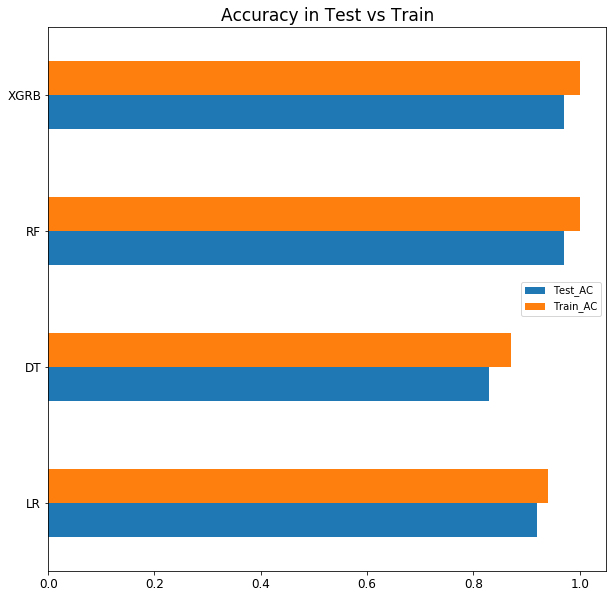

In [13]:
# graphing the accuracy for each model
model_accuracy.plot(kind='barh',figsize=(10, 10), fontsize=12)
plt.title('Accuracy in Test vs Train', fontsize=17)
plt.ylabel('', fontsize=16)
plt.show()

In [27]:
model_accuracy

,Test_AC,Train_AC
Model,,
LR,0.92,0.94
DT,0.83,0.87
RF,0.97,1.00
XGRB,0.97,1.00


After this quick analysis we can see that the models doenst have an evident overfiting, because the diference beetween the test and train data isnt considerable

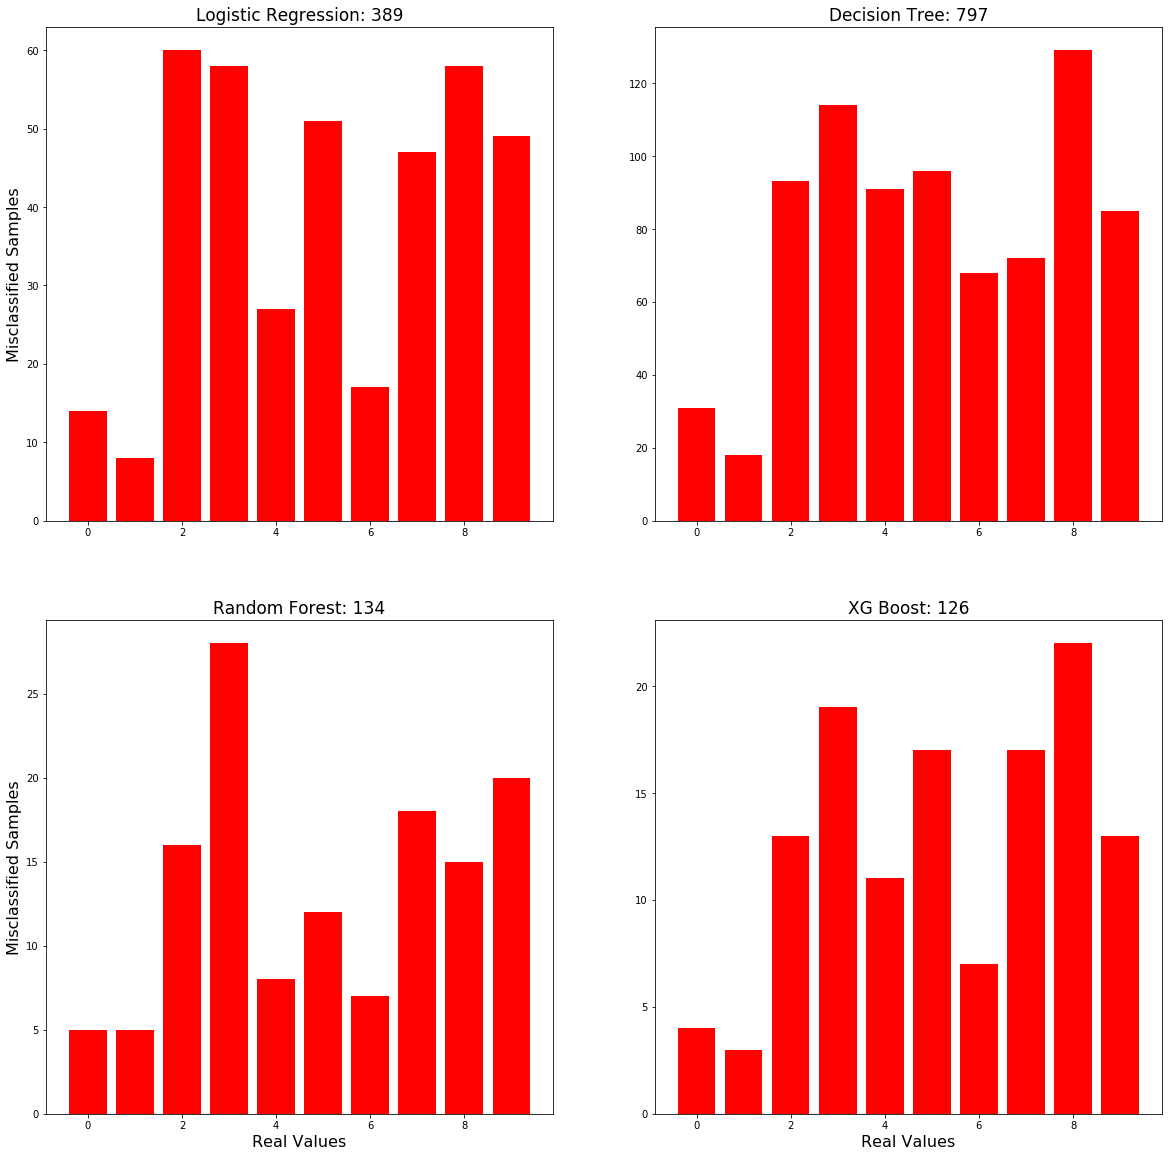

In [16]:
# graphing the missclasified samples for each model

plt.figure(figsize=(20, 20))

# Logistic Regression
plt.subplot(221)

plt.bar(height=pred_lr_ms['pred_false'], x=pred_lr_ms.index, color='red')
plt.ylabel('Misclassified Samples', fontsize=16)
pred_lr_ms_sum = pred_lr_ms['pred_false'].sum().astype(int)
plt.title(f'Logistic Regression: {pred_lr_ms_sum}', fontsize=17)

# Decision Tree
plt.subplot(222)

plt.bar(height = pred_dt_ms['pred_false'], x=pred_dt_ms.index, color='red')
pred_dt_ms_sum = pred_dt_ms['pred_false'].sum().astype(int)
plt.title(f'Decision Tree: {pred_dt_ms_sum}', fontsize=17)

# Random Forest
plt.subplot(223)

plt.bar(height=pred_rf_ms['pred_false'], x=pred_rf_ms.index, color='red')
plt.xlabel('Real Values', fontsize=16)
plt.ylabel('Misclassified Samples', fontsize=16)
pred_rf_ms_sum = pred_rf_ms['pred_false'].sum().astype(int)
plt.title(f'Random Forest: {pred_rf_ms_sum}', fontsize=17)

# XG Boost
plt.subplot(224)

plt.bar(height=pred_xgrb_ms['pred_false'], x=pred_xgrb_ms.index, color='red')
plt.xlabel('Real Values', fontsize=16)
pred_xgrb_ms_sum = pred_xgrb_ms['pred_false'].sum().astype(int)
plt.title(f'XG Boost: {pred_xgrb_ms_sum}', fontsize=17)

plt.show()

## Clasification Report for each Model

## Logistic Regression

In [17]:
print(pred_lr_cr)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       415
           1       0.94      0.98      0.96       523
           2       0.91      0.88      0.90       516
           3       0.90      0.88      0.89       494
           4       0.92      0.94      0.93       444
           5       0.87      0.88      0.88       430
           6       0.94      0.97      0.95       494
           7       0.94      0.91      0.93       538
           8       0.89      0.88      0.88       474
           9       0.91      0.90      0.90       472

    accuracy                           0.92      4800
   macro avg       0.92      0.92      0.92      4800
weighted avg       0.92      0.92      0.92      4800



## Decision Tree

In [18]:
print(pred_dt_cr)

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       415
           1       0.90      0.97      0.93       523
           2       0.83      0.82      0.83       516
           3       0.79      0.77      0.78       494
           4       0.80      0.80      0.80       444
           5       0.76      0.78      0.77       430
           6       0.89      0.86      0.88       494
           7       0.90      0.87      0.89       538
           8       0.81      0.73      0.77       474
           9       0.74      0.82      0.78       472

    accuracy                           0.83      4800
   macro avg       0.83      0.83      0.83      4800
weighted avg       0.83      0.83      0.83      4800



## Random Forest

In [19]:
print(pred_rf_cr)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       415
           1       0.98      0.99      0.99       523
           2       0.96      0.97      0.97       516
           3       0.96      0.94      0.95       494
           4       0.96      0.98      0.97       444
           5       0.97      0.97      0.97       430
           6       0.99      0.99      0.99       494
           7       0.98      0.97      0.97       538
           8       0.96      0.97      0.96       474
           9       0.97      0.96      0.97       472

    accuracy                           0.97      4800
   macro avg       0.97      0.97      0.97      4800
weighted avg       0.97      0.97      0.97      4800



## XG Boost

In [20]:
print(pred_xgrb_cr)

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       415
         1.0       0.98      0.99      0.99       523
         2.0       0.96      0.97      0.97       516
         3.0       0.98      0.96      0.97       494
         4.0       0.97      0.98      0.97       444
         5.0       0.98      0.96      0.97       430
         6.0       0.98      0.99      0.98       494
         7.0       0.99      0.97      0.98       538
         8.0       0.96      0.95      0.95       474
         9.0       0.97      0.97      0.97       472

    accuracy                           0.97      4800
   macro avg       0.97      0.97      0.97      4800
weighted avg       0.97      0.97      0.97      4800



## Training Results

## Logistic Regression

In [21]:
pd.DataFrame(lr_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt,param_dt__max_iter,param_dt__solver,param_scaler__with_std,param_scaler,param_scaler__norm,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,90.217180,2.355714,0.185019,0.028745,"LogisticRegression(C=1.0, class_weight=None, d...",150,lbfgs,True,NaN,NaN,...,0.914658,0.913752,0.917920,0.907411,0.907773,0.911941,0.914296,0.913520,0.003941,7
1,88.321292,1.530569,0.143300,0.020244,"LogisticRegression(C=1.0, class_weight=None, d...",150,lbfgs,False,NaN,NaN,...,0.917014,0.918282,0.913571,0.906142,0.911216,0.911035,0.911035,0.913321,0.003813,8
2,1013.794304,1.107258,0.118059,0.014571,"LogisticRegression(C=1.0, class_weight=None, d...",150,saga,True,NaN,NaN,...,0.919551,0.921906,0.921000,0.920094,0.917558,0.913752,0.917376,0.919101,0.003368,3
3,1010.589540,2.269747,0.092269,0.016088,"LogisticRegression(C=1.0, class_weight=None, d...",150,saga,False,NaN,NaN,...,0.919732,0.917739,0.916470,0.909585,0.912303,0.912847,0.913571,0.915332,0.003828,6
4,65.986691,9.765787,0.180859,0.012702,"LogisticRegression(C=1.0, class_weight=None, d...",150,lbfgs,NaN,"Normalizer(copy=True, norm='max')",l1,...,0.846530,0.849067,0.848161,0.844899,0.842725,0.843993,0.843269,0.845865,0.003031,9
5,87.381398,2.162852,0.143649,0.014892,"LogisticRegression(C=1.0, class_weight=None, d...",150,lbfgs,NaN,"Normalizer(copy=True, norm='max')",l2,...,0.917014,0.920275,0.917014,0.914840,0.915021,0.914115,0.919369,0.916618,0.003215,4
6,82.753476,3.413176,0.137027,0.021687,"LogisticRegression(C=1.0, class_weight=None, d...",150,lbfgs,NaN,"Normalizer(copy=True, norm='max')",max,...,0.921725,0.924805,0.923174,0.917558,0.917376,0.918101,0.921000,0.920985,0.003075,2
7,107.309760,10.507532,0.125974,0.009646,"LogisticRegression(C=1.0, class_weight=None, d...",150,saga,NaN,"Normalizer(copy=True, norm='max')",l1,...,0.846349,0.849067,0.848161,0.844899,0.842906,0.843812,0.843450,0.845811,0.003101,10
8,139.987535,4.830789,0.092269,0.007036,"LogisticRegression(C=1.0, class_weight=None, d...",150,saga,NaN,"Normalizer(copy=True, norm='max')",l2,...,0.917195,0.920275,0.917014,0.915021,0.914477,0.913752,0.919551,0.916546,0.003313,5
9,987.057152,54.402229,0.086623,0.004338,"LogisticRegression(C=1.0, class_weight=None, d...",150,saga,NaN,"Normalizer(copy=True, norm='max')",max,...,0.922269,0.923537,0.923899,0.916833,0.919188,0.917920,0.921363,0.921057,0.003365,1


## Decision Tree

In [22]:
pd.DataFrame(dt_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt,param_dt__max_depth,param_scaler__with_std,param_scaler,param_scaler__norm,param_scaler__threshold,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,17.326986,0.213278,0.175703,0.010631,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",5,True,NaN,NaN,NaN,...,0.677659,0.675122,0.673854,0.670411,0.666063,0.674035,0.686537,0.674718,0.006881,15
1,15.143396,0.295196,0.127115,0.029036,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",5,False,NaN,NaN,NaN,...,0.677659,0.675122,0.673854,0.670411,0.666063,0.674035,0.686537,0.674718,0.006881,15
2,19.038673,0.502816,0.176380,0.045046,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",6,True,NaN,NaN,NaN,...,0.734010,0.738540,0.726762,0.718971,0.725131,0.727849,0.735097,0.731718,0.006327,10
3,17.102826,1.150246,0.131764,0.027528,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",6,False,NaN,NaN,NaN,...,0.734010,0.738540,0.726762,0.719152,0.724950,0.727668,0.734916,0.731664,0.006289,11
4,23.289003,0.268028,0.184423,0.038917,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",9,True,NaN,NaN,NaN,...,0.838014,0.840732,0.838558,0.831310,0.834934,0.832035,0.831491,0.836081,0.003635,3
5,21.584324,0.643064,0.146398,0.019634,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",9,False,NaN,NaN,NaN,...,0.839464,0.838920,0.838377,0.830766,0.835296,0.831491,0.831129,0.835973,0.003921,4
6,18.197492,0.081825,0.207178,0.033675,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",5,NaN,"Normalizer(copy=True, norm='l2')",l1,NaN,...,0.658996,0.664251,0.659177,0.660989,0.657909,0.659902,0.664613,0.661799,0.003643,18
7,17.856472,0.234431,0.180009,0.032666,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",5,NaN,"Normalizer(copy=True, norm='l2')",l2,NaN,...,0.657547,0.661533,0.659177,0.661171,0.658090,0.660989,0.664432,0.661581,0.004180,19
8,13.626702,0.085149,0.162740,0.029647,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",5,NaN,"Normalizer(copy=True, norm='l2')",max,NaN,...,0.677115,0.674941,0.673854,0.670592,0.666063,0.674035,0.686537,0.674446,0.007259,17
9,20.765401,0.365100,0.189692,0.013224,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",6,NaN,"Normalizer(copy=True, norm='l2')",l1,NaN,...,0.714622,0.721870,0.716978,0.715528,0.710274,0.720783,0.718608,0.717948,0.005129,13


## Random Forest

In [23]:
pd.DataFrame(rf_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt,param_dt__bootstrap,param_dt__max_depth,param_dt__min_samples_leaf,param_dt__n_estimators,param_scaler__with_std,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,376.445978,3.020293,3.167030,0.361219,"RandomForestClassifier(bootstrap=False, ccp_al...",True,100,3,500,True,...,0.965755,0.968654,0.962131,0.963580,0.963762,0.968110,0.964305,0.965810,0.002267,24
1,375.676825,4.016717,2.966644,0.419878,"RandomForestClassifier(bootstrap=False, ccp_al...",True,100,3,500,False,...,0.965030,0.969560,0.964305,0.963399,0.963580,0.969379,0.965392,0.965774,0.002256,25
2,613.868614,24.567814,4.498974,0.567725,"RandomForestClassifier(bootstrap=False, ccp_al...",True,100,3,800,True,...,0.965392,0.967929,0.964124,0.964486,0.963218,0.967929,0.966479,0.965919,0.001937,22
3,598.148359,3.939247,4.154724,0.210071,"RandomForestClassifier(bootstrap=False, ccp_al...",True,100,3,800,False,...,0.965573,0.968110,0.964849,0.964668,0.962493,0.968110,0.965211,0.965629,0.001715,27
4,362.483617,2.267863,2.484566,0.075116,"RandomForestClassifier(bootstrap=False, ccp_al...",True,100,5,500,True,...,0.963218,0.965030,0.960138,0.962131,0.959051,0.964305,0.960862,0.962350,0.002067,44
5,362.358065,4.792959,2.441112,0.021331,"RandomForestClassifier(bootstrap=False, ccp_al...",True,100,5,500,False,...,0.963399,0.965573,0.960138,0.960500,0.960681,0.965211,0.961768,0.962929,0.002121,38
6,579.947019,7.887904,3.883066,0.031040,"RandomForestClassifier(bootstrap=False, ccp_al...",True,100,5,800,True,...,0.962312,0.964668,0.961406,0.961768,0.961225,0.966117,0.961406,0.962730,0.001603,42
7,575.249044,0.880367,3.883574,0.052808,"RandomForestClassifier(bootstrap=False, ccp_al...",True,100,5,800,False,...,0.963762,0.965030,0.960500,0.961587,0.960500,0.965573,0.962312,0.963020,0.001828,37
8,376.094352,1.823592,2.520802,0.020453,"RandomForestClassifier(bootstrap=False, ccp_al...",True,120,3,500,True,...,0.965030,0.968835,0.963580,0.963580,0.963943,0.967567,0.965936,0.965720,0.001865,26
9,374.463443,1.074614,2.502445,0.021487,"RandomForestClassifier(bootstrap=False, ccp_al...",True,120,3,500,False,...,0.966298,0.968654,0.961950,0.963580,0.962312,0.967748,0.965936,0.965629,0.002392,28


## XG Boost

In [24]:
pd.DataFrame(xgrb_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scaler,param_scaler__threshold,param_xgbrg,param_xgbrg__max_depth,param_xgbrg__num_class,param_xgbrg__objective,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,3976.697375,28.691386,2.196011,0.105567,"Binarizer(copy=True, threshold=18.257908978953...",18.2579,"XGBClassifier(base_score=0.5, booster='gbtree'...",10,10,multi:softmax,...,0.970103,0.976083,0.971009,0.973727,0.968110,0.974633,0.973727,0.972007,0.002731,1
1,4456.115117,28.953306,2.088107,0.243607,"StandardScaler(copy=True, with_mean=True, with...",NaN,"XGBClassifier(base_score=0.5, booster='gbtree'...",10,10,multi:softmax,...,0.968835,0.973546,0.967748,0.970103,0.966842,0.973727,0.969741,0.970068,0.002331,2
